# A Multiagent transportation system

Auteur : Philippe Mathieu, [CRISTAL Lab](https://www.cristal.univ-lille.fr/), [SMAC Team](https://www.cristal.univ-lille.fr/?rubrique26&id=7), [University of Lille](http://www.univ-lille1.fr), email : philippe.mathieu@univ-lille.fr

Contributeurs : Corwin Fèvre (CRISTAL/SMAC , CRISTAL/OSM)

Creation : 15/01/2020


## Principe général


Cette feuille fait suite à [mas_basics_fr.ipynb](mas_basics_fr.ipynb) qui donnait les bases de la construction d'un système multi-agents sur un reseau social.
Nous vous montrons ici, comment réaliser une petite simulation d'un système de co-voiturage à l'aide des agents.

# La simulation du trafic

In [2]:
import networkx as nx
import random as random
import matplotlib.pyplot as plt
import itertools
import numpy as np
from timeit import default_timer as timer
from math import ceil, floor

### Abstract class des agents
Afin de pouvoir lesm anipuler simplement dans le SMA

In [3]:
class Agent:
    def __init__(self, unique_id):
        self.is_alive = True
        self.unique_id = unique_id
    
    def update(self) -> None:
        pass
    
    def decide(self) -> None:
        pass

### Agent conducteur
Un agent conducteur dispose d'un trajet : une succession de positions contiguës qu'il va parcourir.
À chaque tick, il supprime le premier élément de son trip, simulant ainsi une avancée dans son voyage.

In [4]:
class DriverAgent(Agent):
    def __init__(self, unique_id, trip):
        super().__init__(unique_id)
        self.trip = trip
        
    def to_string(self):
        print("I am driver",self.unique_id,"- trip:",self.trip)
        
        
    def update(self) :
        pass
    
    def decide(self) :
        if len(self.trip)>0:
            self.trip.pop(0)
        else :
            self.is_alive = False
            if sma.verbose == True:
                print("Driver",self.unique_id,"arrived")
            

### Agent passager
Un agent passager dispose d'un noeud de départ, d'une noeud d'arrivé et d'un noeud actuel.
Son but est de rejoindre son noeud d'arrivé en respectant certains critères, dans notre cas, en minimisant le temps d'attente et la distance parcourue.
Cet agent va générer et mettre à jour son graphe de transition, ce dernier lui permettra de déterminer quel choix faire quant au partage d'un trajet avec un conducteur.
Il disposera d'une heuristique qui sera propre à lui-même (pour l'instant une seule) et fera donc un choix en fonction de son environnement.
Il peut attendre sur sa case, augmentant alors son temps total d'attente, partager un trajet d'un conducteur et faire des détours si ça en vaut la peine.

In [5]:
class RiderAgent(Agent):
    def __init__(self, unique_id, v_dep, v_arr, strategy='transition'):
        super().__init__(unique_id)
        self.v_dep = v_dep
        self.v_r = v_dep
        self.v_arr = v_arr
        self.Av = {self.v_r}
        #self.Ats = dict()
        #self.Ats[self.v_r]={'distance':0}
        self.Ad = []
        self.G_ts = None
        self.wt = 0
        self.compute_time = None
        self.strategy = strategy
        
    def to_string(self):
        print("I am rider",self.unique_id,"- dep:",self.v_dep,", arr:",self.v_arr)
        
    def generate_transition_graph_v2(self):
        '''Fonction permettant la création du graphe de transition'''
        #On initialise le graphe avec le noeud de départ
        self.G_ts = nx.MultiDiGraph()
        self.G_ts.add_node(self.v_r, distance=0)
        
        #pour chaque véhicule passant sur la case du passager, on va identifier 
        #tout les noeuds accessibles à partir de ces derniers, 
        #récursivement grâce à la méthode create_nodes_of_ad()
        for ad in self.Ad[self.v_r]:
            d_time_left = ad[2]
            r_time_left = 0
            if d_time_left >= r_time_left :
                distance = d_time_left
                node = self.create_nodes_of_ad(ad, distance)
                #print("node from recurs on vr",node)
                contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=node, target=self.v_arr)
                delay = d_time_left
                self.G_ts.add_edge(self.v_r, node, d=ad, contrib=contrib, delay=delay)
        
    def create_nodes_of_ad(self, ad, prev_distance):
        '''Fonction récursive permettant de parcourir les noeuds disponibles à partir
        du trajet d'un conducteur ad.
        - si l'on trouve un noeuds de transition on passe à un autre conducteur 
        - sinon on identifie le noeuds le plus interessant à garder'''
        
        #on commence par récuperer le trajet du conducteur et la distance du noeud précédent 
        #puis on initialiser quelques flags var
        trip = ad[1][1:]
        first_node = None
        last_created_node = None
        distance = prev_distance + ad[2]

        #pour chaque noeuds du trajet du véhicule
        for i in range(len(trip)):
            node = trip[i]
            distance += 1
            #si il existe une transition avec d'autres conducteurs
            if node in self.Ad.keys() and len(self.Ad[node] > 1):
                other_Ad = [ads for ads in self.Ad[node] if ads[0]!=ad[0]]
                #pour chacun de ces autres conducteurs
                for d in other_Ad:
                    d_time_left = d[2]
                    #si la transition est faisable en temps/distance
                    if d_time_left >= distance :
                        #si le noeud n'éxiste pas encore dans le graphe, on l'ajoute
                        if not (self.G_ts.has_node(node)):
                                self.G_ts.add_node(node, distance=distance)
                        #si c'est le premier noeud qu'on ajoute pour cette transition, on le garde
                        #c'est sur ce noeud qu'on connectera le graphe et les noeuds nouvellement créé
                        if first_node == None:
                            first_node = node
                        
                        #sinon, on lie simplement le noeud au noeud précédent
                        else :
                            contrib = nx.shortest_path_length(sma.graph, source=last_created_node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=node, target=self.v_arr)
                            delay = 0
                            self.G_ts.add_edge(last_created_node, node, d=ad, contrib=contrib, delay=delay)
                        
                        #on met à jour le dernier noeud créé afin de pouvoir y lier le prochain si necessaire
                        last_created_node = node

                        #on va par la suite vérifier récursivement si pour ce conducteur, 
                        #il n'éxiste pas d'autres transition ou noeuds interessant
                        new_node = self.create_nodes_of_ad(d, distance)
                        contrib = nx.shortest_path_length(sma.graph, source=node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
                        delay = d_time_left - distance
                        self.G_ts.add_edge(node, res, d=d, contrib=contrib, delay=delay)

        #si l'on n'a trouvé aucun transition dans le trip du conducteur
        #on va tout de même regarder si il n'a pas de noeuds interessants
        if first_node == None:
            full_trip = ad[1]
            #on part du dernier noeuds et on recupère sa contribution
            last_node = full_trip[-1]
            source_node = full_trip[0]
            contrib = nx.shortest_path_length(sma.graph, source=source_node, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=last_node, target=self.v_arr)
            #print("contrib",contrib)
            
            #si la taille du voyage est inférieur ou égal à 2
            #ça veut dire qu'il ne reste au condcuteur qu'un seul noeud à parcourir avant sa destination
            #donc on ajoute ce noeud au graphe
            
            if len(full_trip) <= 2:
                    first_node = last_node
                    
            #sinon, on va vouloir identifier le meilleur noeud a prendre dans le voyage
            #cepandant, calculer la contribution de chaque noeuds c'est faire une différence de chemin
            #le plus court pour chaque noeuds = grande compléxité
            #alors on utilise un petit stratagème :
            else :
                #on va identifier trois cas :
                
                
                #une contribution négative du dernier noeud
                #intuition : il peut y avoir un noeud avec une contribution positive dans le voyage 
                #du conducteur car size(trip)>2 et contrib(source)=0
                if contrib < 0:
                    #on va ici chercher si il existe une contribution non négative dans le voyage du conducteur
                    best_node_index = floor(len(full_trip[:contrib])/2)
                    #si cette contribution est identifiée sur le premier noeud, alors il n'y a auncune contrib +
                    if best_node_index == 0:
                        first_node = full_trip[-1]
                    #sinon c'est qu'il y a un bien une contrib +, et donc on prends ce noeud
                    else :
                        first_node = full_trip[best_node_index]
                        
                #une contribution nul du dernier noeud
                #intuition : il y a un noeud avec une contribution positive dans le voyage 
                #du conducteur car size(trip)>2 et contrib(source)=0
                if contrib == 0 :
                    best_node_index = floor(len(full_trip)/2)
                    first_node = full_trip[best_node_index]
                    #print("=")

                #une contribution positive du dernier noeud
                #il faut pouvoir trouver le meilleur noeud
                if contrib > 0 :
                    tmp = full_trip[contrib:] 
                    best_node_index = floor(len(tmp)/2)
                    first_node = tmp[best_node_index]
                    #print(">")
                    
            #si ce noeud n'éxiste pas on le creer        
            if not (self.G_ts.has_node(first_node)):
                distance = prev_distance + ad[2] + full_trip.index(first_node)
                self.G_ts.add_node(first_node, distance=distance)
        
        #point crucial de la recursion : on retourne toujours le premier noeud créé dans le module du conducteur
        #il servira à ce connecter au reste du graphe
        return first_node
        
    
    
    def best_driver_contrib_and_wait(self):
        '''on parcours tout les chemins possibles du graphe et on identifie le plus interessant
        on renvoie le premier conducteur du meilleur chemin'''
        scores_paths = dict()
        cur_node = self.v_r
        #print(cur_node)
        other_nodes = [node for node in list(self.G_ts.nodes()) if node != cur_node]
        paths = nx.all_simple_paths(self.G_ts, source=cur_node, target=other_nodes)

        #heuristique : suivre le chemin qui rapporte le plus de cases le plus rapidement possible
        for path in paths :
            id_d = None
            score_path = 0
            #print(path)
            for i in range(len(path)):

                if i+1<len(path):
                    data = self.G_ts.get_edge_data(path[i], path[i+1])
                    #print(data)

                    #si il y a plusieurs arretes menants au meme noeuds

                    best_score = None
                    #on est dans un multigraph, donc on prends la meilleur edge
                    for j in range(len(data)):
                        cur_score = data[j]['contrib'] - data[j]['delay']
                        if best_score == None or best_score < cur_score:
                            best_score = cur_score
                            if i==0 :
                                id_d = data[j]['d'][0]

                    score_path += best_score                   

                else :
                    break

            scores_paths[id_d]=score_path
            
        #contrib_pos = [val for val in scores_paths.values() if val >= 0]
        #if len(contrib_pos) > 0:
        bests_d = [key for m in [max(scores_paths.values())] for key,val in scores_paths.items() if val == m]
        random.shuffle(bests_d)
            #print(bests_d)

        for d in self.Ad[cur_node]:
            if d[0] in bests_d and d[2] == 0:
                return(d)
            
        return None

    
    def greedy_strategy(self):
        for ad in self.Ad[self.v_r]:
            next_node = ad[1][1]
            contrib = nx.shortest_path_length(sma.graph, source=self.v_r, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=next_node, target=self.v_arr)
            if contrib > 0:
                return ad
        return None
            
            
    def update(self):
        #timer pour evaluer le temps de réponse d'un agent
        start = timer()
        self.Ad = tsa.get_rider_matched_drivers(self.Av)
        
        if(self.strategy == 'transition'):
            self.generate_transition_graph_v2()
            blacklist = set()
        
        cur_node = self.v_r
        
        
        
        
        #si véhicule présent direct alors on effectue heuritique sinon reste sur son noeud et comportement dif
        
        if len(self.Ad[cur_node]) > 0 and len([driver for driver in self.Ad[cur_node] if driver[2]==0])>0:
            if(self.strategy == 'transition'):
                best_driver = self.best_driver_contrib_and_wait()
            
            elif(self.strategy == 'greedy'):
                best_driver = self.greedy_strategy()
            
            else :
                print("Select valid strategy : greedy, transition")
                
            if best_driver != None :
                
                new_node = best_driver[1][1]
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver)
                
                if new_node == self.v_arr:
                    if sma.verbose == True:
                        print("Rider n°",self.unique_id,"arrived with a waiting time of",self.wt,"ticks")
                    end = timer()
                    self.compute_time = end - start
                    #print(self.compute_time)
                    self.is_alive = False
                    return
                
                if(self.strategy == 'transition'):
                    #on ecrase l'ancien noeud
                    nx.relabel_nodes(self.G_ts, {cur_node:new_node}, copy=False)

                    blacklist = set(cur_node)
            else : 
                if sma.verbose == True:
                    print("Agent rider",self.unique_id,"doesn't move")
                new_node = cur_node
                self.wt += 1
            
            
        else:
            if sma.verbose == True:
                print("Agent rider",self.unique_id,"doesn't move")
            new_node = cur_node
            self.wt += 1
        
        
        self.Av = {new_node}
        if(self.strategy == 'transition'):
            other_nodes = [node for node in list(self.G_ts.nodes()) if node != new_node]
            for node in other_nodes:

                if nx.has_path(self.G_ts,new_node,node):
                    bl_node = nx.shortest_path(self.G_ts, new_node, node)[-2]
                    edge_data = self.G_ts.get_edge_data(bl_node,node)

                        #si il y a plusieurs arretes menants au meme noeud
                    for j in range(len(edge_data)): 

                        d = edge_data[j]['d']
                        self.Av.union(set(d[1]))

                else :
                    blacklist.add(node)
                    self.G_ts.remove_node(node)
                    
            self.Av.difference(blacklist)


        self.v_r = new_node
        end = timer()
        self.compute_time = end - start
        
    def decide(self):
        pass

### L'agent service de transport :
Cet agent référence, à chaque début de tick et pour chaque noeuds, les conducteurs passant par un noeud.
Son but principal et d'éviter de multiples appels et parcours des différents agents conducteurs par de nombreux agents passagers.
Il créer donc un dictionnaire prenant pour clé un noeud et pour valeur une liste de conducteurs.

In [6]:
class TransportServiceAgent(Agent):
    #tsa
    def __init__(self, unique_id):
        super().__init__(unique_id)
        self.drivers_nodes_tracker = dict()
    
     
    def get_rider_matched_drivers(self, Av):
        Ad = dict()
        for av in Av:
            Ad[av] = self.drivers_nodes_tracker[av]
        
        #print("\n ad :", Ad)
        return Ad
    
    def update(self):
        drivers = [agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")]
        
        for node in list(sma.graph.nodes()):
            self.drivers_nodes_tracker[node] = list()
            
        for key in list(self.drivers_nodes_tracker.keys()):
            for driver in drivers :   
                if key in driver.trip:
                    m_idx = driver.trip.index(key)
                    sub_trip = driver.trip[m_idx:]
                    #on verifie que le noeud de transition n'est pas l'arrive du conducteur
                    if len(sub_trip) > 1:
                        self.drivers_nodes_tracker[key].append((driver.unique_id, driver.trip[m_idx:], m_idx))
        #print("\n driver node tracker :", self.drivers_nodes_tracker)
        
    def decide(self):
        pass

### L'agent générateur de traffic
Cet agent va nous permettra d'insérer de nouveaux agents conducteurs et passagers dans le trafic tout en modulant leur nombre en fonction de la taille de l'environnement et d'un indice de croissance.
Ainsi, plus l'environnement et grand, plus il y a d'agents. Plus l'indice de croissance est grand, plus souvent il y a d'agents générés.

In [7]:
class GeneratorAgent(Agent):
    def __init__(self, growth_rate, current_id, rider_gen=False, rider_strat="transition"):
        super().__init__(current_id)
        self.n_id = current_id+1
        self.growth_rate = growth_rate #permet de gerer la vitesse d'expansion du nombre de voitures 
        #Valeur entre ]0,1], 0 = 0%, 1 = 100%
        self.system_occupency = 0
        self.rider_gen = rider_gen
        self.rider_strat = rider_strat
        
    def next_id(self):
        self.n_id += 1
        return self.n_id

    

    #genere les agents voitures
    def driverAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2) 
        trip = nx.shortest_path(graph, n1, n2)
        d = DriverAgent(self.next_id(), trip)
        if sma.verbose == True:
            d.to_string()
        sma.addAgent(d)
        

    #genere les agents passagers
    def riderAgentGenerator(self):
        n1, n2 = random.sample(list(sma.graph.nodes),2)    
        r = RiderAgent(self.next_id(), n1, n2, self.rider_strat)
        if sma.verbose == True:
            r.to_string()
        sma.addAgent(r)
        
    def update(self):
        nb_nodes = len(list(sma.graph.nodes))
        nb_drivers = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "DriverAgent")])
        self.trafic_indicator = (nb_drivers/nb_nodes) *100
        system_difference = nb_nodes - nb_drivers
        if system_difference > 0:
            nb_to_gen = random.randrange(int(system_difference*self.growth_rate))
            for i in range(nb_to_gen):
                self.driverAgentGenerator()
            if sma.verbose == True:
                print(nb_to_gen,"drivers generated.")
            
        if self.rider_gen == True:
            nb_riders = len([agent for agent in sma.agentList if (agent.__class__.__name__ == "RiderAgent")])
            system_difference = (nb_nodes - nb_riders)/2
            if system_difference > 0:
                nb_to_gen = random.randrange(int(system_difference*self.growth_rate))
                for i in range(nb_to_gen):
                    self.riderAgentGenerator()
                if sma.verbose == True:
                    print(nb_to_gen,"riders generated.")
                
    def decide(self):
        pass
        

### Le Système multi-agents
Le SMA va encadrer le tour de parole des agents, la liste des agents présents/vivants dans le système et récupérer les données issues d'une simulation.

In [99]:
class SMA:
    def __init__(self, agentList, graph, verbose=False):
        self.tick = 0
        self.agentList = agentList
        self.graph = graph
        self.wt_collector = []
        self.wt_keeper = []
        self.compute_collector = []
        self.compute_keeper = []
        self.trafic_collector = []
        self.verbose = verbose
        
    def addAgent(self,ag):
          self.agentList.append(ag)
            
    def run(self, rounds=None):
        if rounds==None:
            #tant que tout les agents passagers ne sont pas arrivés à destination
            while len([agent for agent in self.agentList if (agent.__class__.__name__ == "RiderAgent")]) > 0:
                self.runOnce()
        else :
            #on fait un nombre de tour précis
            for i in range(0,rounds):
                self.runOnce()

    def runOnce(self):
        self.tick += 1
        
        
        for agent in self.agentList:
            agent.update()
            agent.decide()
            
        #on nettoie la liste des agents
        wt_tick = []
        compute_tick = []
        for a in agentList :
            if a.__class__.__name__ == "RiderAgent":
                if a.is_alive == False:
                    self.wt_keeper.append(a.wt)
                    self.compute_keeper.append(a.compute_time)
                    self.agentList.remove(a)
                else :
                    wt_tick.append(a.wt)
                    compute_tick.append(a.compute_time)
                 
            elif a.__class__.__name__ == "GeneratorAgent":
                self.trafic_collector.append(a.trafic_indicator)
                
            elif a.__class__.__name__ == "DriverAgent":
                 if a.is_alive == False:
                    self.agentList.remove(a)

        #print(wt_tick)
        self.wt_collector.append(np.mean(wt_tick+self.wt_keeper))
        self.compute_collector.append(np.mean(compute_tick+self.compute_keeper))
        if self.verbose:
            print("tick " + str(self.tick) + " ended")

## Expériences et analyses

### Première expérience : 
Instance :
- Graphe en grille -> 32 * 32 -> 1024 noeuds
- Environ 20000 agents générés
- Deux strategies, notre modèle décrit plus haut et une naïve (premier agent contribuant)
- 250 ticks

Etude :
- Temps d'attente
- Temps d'éxecution de la décision d'un agent passager

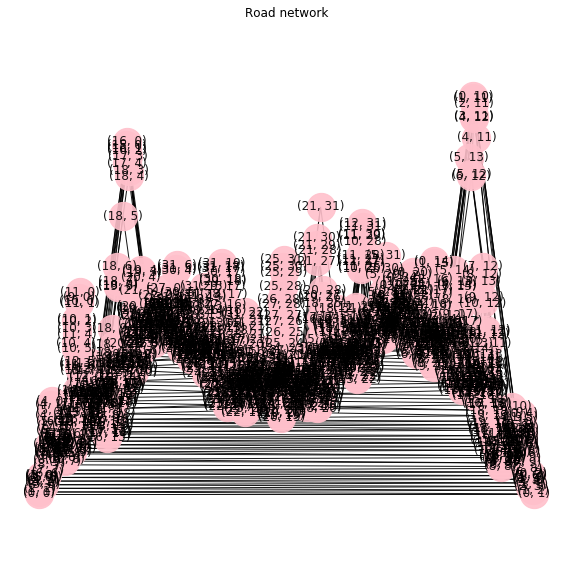

In [27]:
graph = nx.grid_2d_graph(32,32)


plt.figure(figsize=(10,10))    # pour définir la taille de la figure
pos = nx.planar_layout(graph)
nx.draw_networkx(graph,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
plt.title("Road network")
plt.axis('off')
plt.show()


In [69]:
print("Nombre de noeuds :",len(graph.nodes))

Nombre de noeuds : 1024


In [35]:
%%time
tsa = TransportServiceAgent(0)
gen = GeneratorAgent(1,1,True)
agentList = [gen, tsa]
    
sma = SMA(agentList, graph)
sma.run(250)

tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
tick 21 ended
tick 22 ended
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
tick 30 ended
tick 31 ended
tick 32 ended
tick 33 ended
tick 34 ended
tick 35 ended
tick 36 ended
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
tick 56 ended
tick 57 ended
tick 58 ended
tick 59 ended
tick 60 ended
tick 61 ended
tick 62 ended
tick 63 ended
tick 64 ended
tick 65 ended
tick 66 ended
tick 67 ended
tick 68 ended
tick 69 ended
tick 70 ended
tick 71 ended
tick 72 ended
t

In [36]:
#petite partie servant à afficher le graphe de transition d'un agent rider
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10,10))    # pour définir la taille de la figure
# G_ts = sma.agentList[11].G_ts
# pos = nx.spring_layout(G_ts)
# #labels = nx.get_node_attributes(G_ts, 'distance') 
# nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
# nx.draw_networkx_edge_labels(G_ts,pos=pos)
# #nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
# plt.axis('off')
# plt.show()
# print( nx.get_node_attributes(G_ts, 'distance') )

In [65]:
wt_transition = sma.wt_collector
comp_transition = sma.compute_collector
print("nombre d'agents total :",sma.agentList[-1].unique_id)
print("Temps moyen d'attente", round(wt_transition[-1],2), "ticks")
print("Temps moyen de calcul pour un agent passager",round(comp_transition[-1]*1000,2),"ms")

nombre d'agents total : 17997
Temps moyen d'attente 9.96 ticks
Temps moyen de calcul pour un agent passager 3.27 ms


In [32]:
%%time
tsa = TransportServiceAgent(0)
gen = GeneratorAgent(1,1,True,'greedy')
agentList = [gen, tsa]
    
sma = SMA(agentList, graph)
sma.run(250)
wt_greedy = sma.wt_collector
comp_greedy = sma.compute_collector

tick 1 ended
tick 2 ended
tick 3 ended
tick 4 ended
tick 5 ended
tick 6 ended
tick 7 ended
tick 8 ended
tick 9 ended
tick 10 ended
tick 11 ended
tick 12 ended
tick 13 ended
tick 14 ended
tick 15 ended
tick 16 ended
tick 17 ended
tick 18 ended
tick 19 ended
tick 20 ended
tick 21 ended
tick 22 ended
tick 23 ended
tick 24 ended
tick 25 ended
tick 26 ended
tick 27 ended
tick 28 ended
tick 29 ended
tick 30 ended
tick 31 ended
tick 32 ended
tick 33 ended
tick 34 ended
tick 35 ended
tick 36 ended
tick 37 ended
tick 38 ended
tick 39 ended
tick 40 ended
tick 41 ended
tick 42 ended
tick 43 ended
tick 44 ended
tick 45 ended
tick 46 ended
tick 47 ended
tick 48 ended
tick 49 ended
tick 50 ended
tick 51 ended
tick 52 ended
tick 53 ended
tick 54 ended
tick 55 ended
tick 56 ended
tick 57 ended
tick 58 ended
tick 59 ended
tick 60 ended
tick 61 ended
tick 62 ended
tick 63 ended
tick 64 ended
tick 65 ended
tick 66 ended
tick 67 ended
tick 68 ended
tick 69 ended
tick 70 ended
tick 71 ended
tick 72 ended
t

In [67]:
print("nombre d'agents total :",sma.agentList[-1].unique_id)
print("Temps moyen d'attente", round(wt_greedy[-1],2), "ticks")
print("Temps moyen de calcul pour un agent passager",round(comp_greedy[-1]*1000,2),"ms")


nombre d'agents total : 17997
Temps moyen d'attente 12.38 ticks
Temps moyen de calcul pour un agent passager 0.12 ms


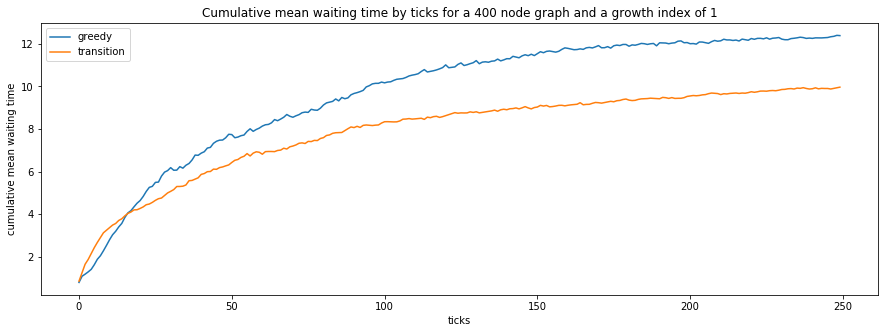

In [46]:
f = plt.figure(figsize=(15, 5))
plt.plot(wt_greedy,label = 'greedy')
plt.plot(wt_transition,label = 'transition')
plt.xlabel('ticks')
plt.ylabel('cumulative mean waiting time')
plt.title('Cumulative mean waiting time by ticks for a 400 node graph and a growth index of 1')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/wt_trans_greedy_1000_1_250ticks", bbox_inches='tight')

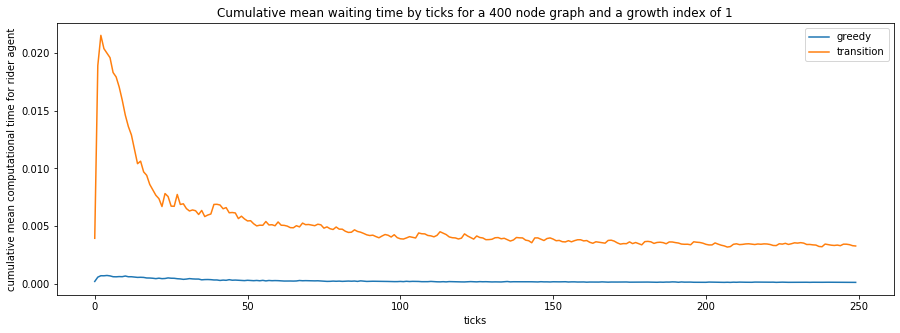

In [45]:
f = plt.figure(figsize=(15, 5))
plt.plot(comp_greedy,label = 'greedy')
plt.plot(comp_transition,label = 'transition')
plt.xlabel('ticks')
plt.ylabel('cumulative mean computational time for rider agent')
plt.title('Cumulative mean waiting time by ticks for a 400 node graph and a growth index of 1')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/comp_trans_greedy_1000_1_250ticks", bbox_inches='tight')

In [58]:
print("Quand le système est stabilisé :")
p_wt = ((wt_transition[-1] - wt_greedy[-1])/wt_greedy[-1]) *100
print("On a donc une différence de",round(p_wt,1),"% du temps d'attente en utilisant notre méthode")
p_comp = ((comp_transition[-1] - comp_greedy[-1])/comp_greedy[-1]) *100
print("On a donc une différence de",round(p_comp,1),"% du temps d'execution en utilisant notre méthode")

Quand le système est stabilisé :
On a donc une différence de -19.5 % du temps d'attente en utilisant notre méthode
On a donc une différence de 2731.3 % du temps d'execution en utilisant notre méthode


In [68]:
print("Sur la totalité de la simulation (en moyenne) :")
p_wt = ((np.mean(wt_transition) - np.mean(wt_greedy))/np.mean(wt_greedy)) *100
print("On a donc une différence de",round(p_wt,1),"% du temps d'attente en utilisant notre méthode")
p_comp = ((np.mean(comp_transition) - np.mean(comp_greedy))/np.mean(comp_greedy)) *100
print("On a donc une différence de",round(p_comp,1),"% du temps d'execution en utilisant notre méthode")

Sur la totalité de la simulation (en moyenne) :
On a donc une différence de -18.7 % du temps d'attente en utilisant notre méthode
On a donc une différence de 2141.9 % du temps d'execution en utilisant notre méthode


### Comparaison temps d'éxécution et d'attente en fonction de la taille des instances

In [73]:
import pandas as pd

In [75]:
df = pd.DataFrame(columns=["size_env","node_nb","strategy"])

,0,node_nb,size_env,strategy
0,1.0,NaN,NaN,NaN
1,2.0,NaN,NaN,NaN
2,3.0,NaN,NaN,NaN


In [118]:
#constantes computuationelles
type_graph = 'grid2D'
nb_rep = 5
taille_env = [3,5,10,12,15,17,20,23,26,28,31]
#taille_env = [3,5]
strategies_env = ["greedy","transition"]
tick_nb = 250


#stockage
data = []

#gathering datas
for env in taille_env :
    print("---Begin",env,"---\n")
    graph = nx.grid_2d_graph(env,env)
    for strat in strategies_env :
        wt_tot = []
        comp_tot = []
        nb_agents_tot = []
        nb_nodes_tot = []
        for i in range(nb_rep):
            print("occur n°",i)
            tsa = TransportServiceAgent(0)
            gen = GeneratorAgent(1,1,True,strat)
            agentList = [gen, tsa]

            sma = SMA(agentList, graph)
            sma.run(250)
            wt_tot.append(np.mean(sma.wt_collector))
            comp_tot.append(np.mean(sma.compute_collector))
            nb_agents_tot.append(sma.agentList[-1].unique_id)
            nb_nodes_tot.append(len(graph.nodes))
            
        #print("wt",wt_tot)
        #print("comp",comp_tot)
    
        data.append([type_graph, np.mean(nb_nodes_tot), np.mean(nb_agents_tot), strat, tick_nb, np.nanmean(wt_tot), np.nanmean(comp_tot)])
    print("---Ending",env,"---\n")

---Begin 3 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Ending 3 ---

---Begin 5 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Ending 5 ---

---Begin 10 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Ending 10 ---

---Begin 12 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Ending 12 ---

---Begin 15 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Ending 15 ---

---Begin 17 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Ending 17 ---

---Begin 20 ---

occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
occur n° 0
occur n° 1
occur n° 2
occur n° 3
occur n° 4
---Endi

In [119]:
data

[['grid2D',
  9.0,
  473.6,
  'greedy',
  250,
  10.592602345002032,
  8.981441165958998e-06],
 ['grid2D',
  9.0,
  444.8,
  'transition',
  250,
  10.346264930774325,
  5.568345564135894e-05],
 ['grid2D',
  25.0,
  1246.4,
  'greedy',
  250,
  8.7234491834948,
  1.1100646852247032e-05],
 ['grid2D',
  25.0,
  1189.8,
  'transition',
  250,
  7.4763623597483875,
  9.570521939002616e-05],
 ['grid2D',
  100.0,
  3798.4,
  'greedy',
  250,
  8.789962686410071,
  2.04870421694443e-05],
 ['grid2D',
  100.0,
  3627.2,
  'transition',
  250,
  6.600544478750922,
  0.0002549095163314889],
 ['grid2D',
  144.0,
  4941.4,
  'greedy',
  250,
  9.125437019981918,
  2.6016646945896214e-05],
 ['grid2D',
  144.0,
  4779.0,
  'transition',
  250,
  6.4552823317281876,
  0.0003799361251612374],
 ['grid2D',
  225.0,
  6718.8,
  'greedy',
  250,
  9.244346825845202,
  4.010661398026657e-05],
 ['grid2D',
  225.0,
  6594.0,
  'transition',
  250,
  6.292768870229503,
  0.0006720229518741398],
 ['grid2D',
  2

In [120]:
df = pd.DataFrame(data, columns=['graph_type', 'nb_nodes', 'nb_agents', 'strategy', 'nb_ticks','mean_wt','mean_comp_time'])

In [127]:
df

,graph_type,nb_nodes,nb_agents,strategy,nb_ticks,mean_wt,mean_comp_time
0,grid2D,9.0,473.6,greedy,250,10.592602,0.000009
1,grid2D,9.0,444.8,transition,250,10.346265,0.000056
2,grid2D,25.0,1246.4,greedy,250,8.723449,0.000011
3,grid2D,25.0,1189.8,transition,250,7.476362,0.000096
4,grid2D,100.0,3798.4,greedy,250,8.789963,0.000020
5,grid2D,100.0,3627.2,transition,250,6.600544,0.000255
6,grid2D,144.0,4941.4,greedy,250,9.125437,0.000026
7,grid2D,144.0,4779.0,transition,250,6.455282,0.000380
8,grid2D,225.0,6718.8,greedy,250,9.244347,0.000040
9,grid2D,225.0,6594.0,transition,250,6.292769,0.000672


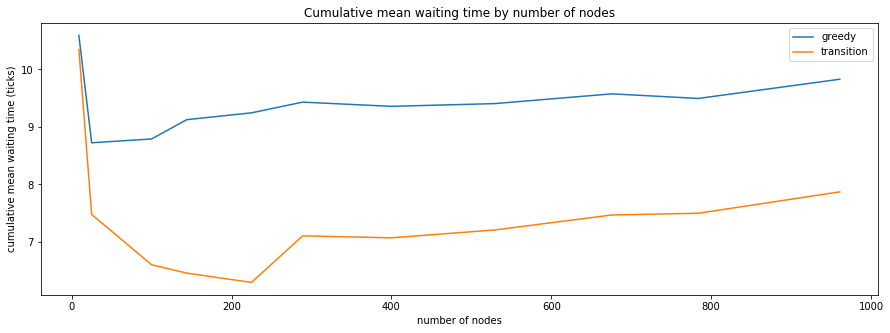

In [148]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy']
trans =  df[df['strategy'] == 'transition']
plt.plot(greedy['nb_nodes'],greedy['mean_wt'], label='greedy')
plt.plot(trans['nb_nodes'],trans['mean_wt'], label='transition')
plt.xlabel('number of nodes')
plt.ylabel('cumulative mean waiting time (ticks)')
plt.title('Cumulative mean waiting time by number of nodes')
plt.legend()
plt.show()
f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/comp_trans_greedy_nbnodes_1_250ticks", bbox_inches='tight')

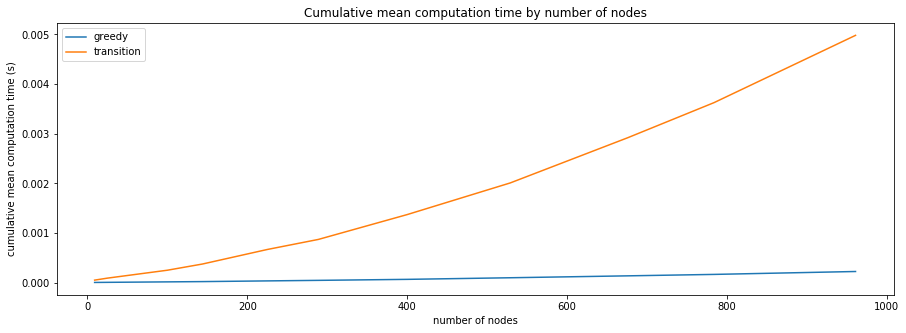

In [149]:
f = plt.figure(figsize=(15, 5))
greedy = df[df['strategy'] == 'greedy']
trans =  df[df['strategy'] == 'transition']
plt.plot(greedy['nb_nodes'],greedy['mean_comp_time'], label='greedy')
plt.plot(trans['nb_nodes'],trans['mean_comp_time'], label='transition')
plt.xlabel('number of nodes')
plt.ylabel('cumulative mean computation time (s)')
plt.title('Cumulative mean computation time by number of nodes')
plt.legend()
plt.show()
#f.savefig("/home/fevrec/Documents/These/these/smac_agents/img/comp_trans_greedy_nbnodes_1_250ticks", bbox_inches='tight')

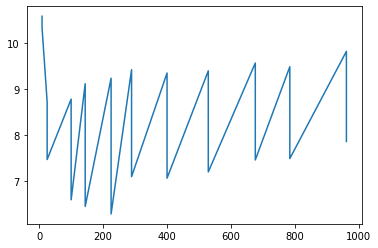

In [123]:
plt.plot(df["nb_nodes"],df["mean_wt"])

In [122]:
df.to_csv("exp1.csv")

# OLD V1

In [ ]:
#     def generate_transition_graph(self):
#         G= nx.MultiDiGraph()
#         #print(self.Ats)
#         G.add_node(self.v_r, distance=0)
#         #il faudra se baser sur ad par la suite
#         for ats, val in self.Ats.items():
#             #print(ats, val)
#             #print(ats)
#             #print(G_ts.nodes())
#             if ats in self.Ad.keys():
#                  #G_ts.add_node(ats, distance=val['distance'])
#                 for ad in self.Ad[ats]:
#                     #print("coucou")
#                     #si le parcours est faisable
#                     #print(ad)
#                     d_time_left = ad[2]
#                     r_time_left = self.Ats[ats]['distance']
#                     d_trip = ad[1]
#                     if d_time_left >= r_time_left :
#                         if not (G.has_node(ats)):
#                             G.add_node(ats, distance=val['distance'])
                        
#                         if self.v_arr in ad[1]:
#                             new_node = self.v_arr
#                             d_subtrip_size = d_trip.index(self.v_arr)
#                             #dist = d_time_left + d_subtrip_size
#                         else :
#                             new_node = ad[1][-1]
#                             d_subtrip_size = len(ad[1]) - 1
#                             #id_d = ad[0]
#                             #TODO il manque qqchose, car si on se base sur le noeuds le plus eloigné il se peut que la contrib soit neg
#                             #alors qu'au final il peut quand meme nous faire gagner qqchose.
                            

#                         #dist : nombres de ticks minimum necessaires pour atteindre un noeuds
                        
#                         dist = d_time_left + d_subtrip_size
                        
#                         #dist = ((d_time_left + r_time_left) - (d_time_left - r_time_left)) + d_subtrip_size
                        
#                         if G.has_node(new_node):
#                             if (dist < G.nodes[new_node]['distance']):
#                                 G.nodes[new_node]['distance'] = dist
#                         else :
#                             G.add_node(new_node, distance=dist)
                        
                        
#                         contrib = nx.shortest_path_length(sma.graph, source=ats, target=self.v_arr) - nx.shortest_path_length(sma.graph, source=new_node, target=self.v_arr)
#                         delay = d_time_left - r_time_left
#                         G.add_edge(ats, new_node, d=ad, contrib=contrib, delay=delay)
                    
#         self.G_ts = G

# def update_v1(self):
#         self.Ad = tsa.get_rider_matched_drivers(self.Av)
#         self.generate_transition_graph()
        
#         cur_node = self.v_r
        
#         blacklist = set()
#         #decision ici:
        
        
#         #si véhicule présent direct alors on effectue heuritique sinon reste sur son noeud et comportement dif
#         #manque un if ici
        
#         #if len([edge for edge in G_ts.out_edges(cur_node) if edge['d'][2]==0]) > 0:
#         if len(self.Ad[cur_node]) > 0 and len([driver for driver in self.Ad[cur_node] if driver[2]==0])>0:
#             best_driver = self.best_driver_contrib_and_wait()
#             #v_r = nouveau noeuds
#             #après decision
#             if best_driver != None :
                
#                 new_node = best_driver[1][1]
#                 #print("new_node",new_node)
#                 #cur_node = new_node
#                 print("Agent rider",self.unique_id,"move from",self.v_r,"to",new_node,"using car",best_driver)
#                 if new_node == self.v_arr:
#                     print("Rider n°",self.unique_id,"arrived with a waiting time of",self.wt,"ticks")
#                     self.is_alive = False
#                     return
#                 #on ecrase l'ancien noeud
#                 nx.relabel_nodes(self.G_ts, {cur_node:new_node}, copy=False)
#                 #G_ts.node[new_node] = G_ts[cur_node]
#                 #print(G_ts.node[new_node])
#                 #G_ts.add_edge(new_node, best_driver[1][-1])
#                 #G_ts.remove_node(cur_node)

#                 blacklist = set(cur_node)
#             else : 
#                 print("Agent rider",self.unique_id,"doesn't move")
#                 new_node = cur_node
#                 self.wt += 1
            
            
#         else:
#             print("Agent rider",self.unique_id,"doesn't move")
#             new_node = cur_node
#             self.wt += 1
        
        
#         self.Av = {new_node}
#         self.Ats = dict()
#         self.Ats[new_node] = {'distance':0}
#         #print("nodes in G_ts",self.G_ts.nodes())
#         other_nodes = [node for node in list(self.G_ts.nodes()) if node != new_node]
#         #print("other_nodes:",other_nodes)
#         for node in other_nodes:
#             #print("haspath_test between:",new_node,node)
#             if nx.has_path(self.G_ts,new_node,node):
#                 self.G_ts.node[node]['distance'] = self.G_ts.node[node]['distance'] - 1
#                 self.Ats[node] = {'distance': self.G_ts.node[node]['distance']}
#                 bl_node = nx.shortest_path(self.G_ts, new_node, node)[-2]
#                 edge_data = self.G_ts.get_edge_data(bl_node,node)
#                 #print(data)

#                     #si il y a plusieurs arretes menants au meme noeuds
#                     #on est dans un multigraph, donc on prends la meilleur edge
#                 #print("recup noeuds possibles, show edge",edge_data)
#                 for j in range(len(edge_data)): 
                   
#                     d = edge_data[j]['d']
#                     self.Av.union(set(d[1]))

#             else :
#                 blacklist.add(node)
#                 self.G_ts.remove_node(node)

#             #clean
#             #self.G_ts.remove_node(cur_node)
        
#         self.v_r = new_node
#         self.Av.difference(blacklist)
#         #print(self.Ats)

# OLD EXP

In [ ]:
# node_list = list(graph.nodes)
# trip1 = nx.shortest_path( graph, random.choice(node_list), random.choice(node_list))
# trip2 = nx.shortest_path( graph, (1, 3), (1, 0))
# print(trip2)
# trip3 = nx.shortest_path( graph, (1, 0), (2, 3))
# trip4 = list(((2,2),(1,2),(0,2),(1,1)))
# trip5 = list(((3,2),(2,2),(2,3),(1,3),(0,3),(0,2)))
# print("\n trip1:",trip1,"\n trip2:",trip2,"\n trip3:",trip3,"\n trip4:",trip4, "\n trip5:",trip5 )

In [ ]:
#agentList = [RiderAgent(0,(1, 1),(1, 3)),RiderAgent(6,(2, 2),(2, 3)), DriverAgent(1, trip1), DriverAgent(2, trip2), DriverAgent(3, trip3), DriverAgent(4, trip4), DriverAgent(5, trip5)]

#sma = SMA(agentList, graph)
#sma.runOnce()

In [ ]:
# tsa = TransportServiceAgent(0)
# agentList = [tsa]
# node_list = list(graph.nodes)
# nb_riders = 5
# nb_drivers = 500
# id_count = 1
# for i in range(nb_riders):
#     n1, n2 = random.sample(node_list,2)    
#     r = RiderAgent(id_count, n1, n2)
#     agentList.append(r)
#     r.to_string()
#     id_count+=1
    
# for i in range(nb_drivers):
#     n1, n2 = random.sample(node_list,2) 
#     trip = nx.shortest_path(graph, n1, n2)
#     d = DriverAgent(id_count, trip)
#     d.to_string()
#     agentList.append(d)
#     id_count+=1
    

    
# sma = SMA(agentList, graph)
# sma.run(10)

In [ ]:
for _ in range(1000):
    agentList = []
    node_list = list(graph.nodes)
    nb_riders = 2
    nb_drivers = 5
    id_count = 0
    for i in range(nb_riders):
        n1, n2 = random.sample(node_list,2)    
        r = RiderAgent(id_count, n1, n2)
        agentList.append(r)
        r.to_string()
        id_count+=1

    for i in range(nb_drivers):
        n1, n2 = random.sample(node_list,2) 
        trip = nx.shortest_path(graph, n1, n2)
        d = DriverAgent(id_count, trip)
        d.to_string()
        agentList.append(d)
        id_count+=1



    sma = SMA(agentList, graph)
    sma.run(5)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[3].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [ ]:
sma = SMA(agentList, graph)
sma.runOnce()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[1].G_ts
pos = nx.spring_layout(G_ts)
#labels = nx.get_node_attributes(G_ts, 'distance') 
nx.draw_networkx(G_ts,pos=pos, edge_color='black',width=1,linewidths=1,node_size=1500,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
#nx.draw_networkx_labels(G_ts,pos=nx.spring_layout(G_ts),labels=labels)
plt.axis('off')
plt.show()
print( nx.get_node_attributes(G_ts, 'distance') )

In [ ]:
sma.runOnce()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))    # pour définir la taille de la figure
G_ts = sma.agentList[0].G_ts
pos = nx.spring_layout(G_ts)
nx.draw_networkx(G_ts,pos=pos,edge_color='black',width=1,linewidths=1,node_size=800,node_color='pink',alpha=0.9)
nx.draw_networkx_edge_labels(G_ts,pos=pos)
plt.axis('off')
plt.show()


Il a l'air de bien arriver à (1,3) donc ça marche pas trop mal, l'affichage est pourri par contre...

# Bibliographie

Philippe Mathieu, Yann Secq.
Environment Updating and Agent Scheduling Policies in Agent-based Simulators. 
ICAART Conference, 2012, pp 170-175

Philippe Mathieu, Sébastien Picault, Yann Secq.
Design Patterns for Environments in Multi-agent Simulations. 
PRIMA Conference, 2015, pp 678-686

Philippe Mathieu, Gildas Morvan, Sébastien Picault.
Multi-level agent-based simulations: Four design patterns. 
Journal of Simulation Modelling Practice and Theory, Janv 2018
